# Benchmarking Numberlink Solvers

In [1]:
import sys
import os

# Add the `backend` folder to the path
sys.path.append(os.path.abspath("../backend"))
sys.path.append(os.path.abspath("../experiment/grids"))

In [2]:
import time

from constraint_solver_path import ConstraintPathSolver
from pyco_solver_path import PycoPathSolver
from pyco_solver_edge import PycoEdgeSolver

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def run_constraint_path_solver(puzzle):
    solver = ConstraintPathSolver(puzzle)
    return solver.solve()

def run_pyco_path_solver(puzzle):
    solver = PycoPathSolver(puzzle)
    return solver.solve()

def run_pyco_edge_solver(puzzle):
    solver = PycoEdgeSolver(puzzle)
    return solver.solve()


solvers = {
    "ConstraintPathSolver": run_constraint_path_solver,
    "PycoPathSolver": run_pyco_path_solver,
    "PycoEdgeSolver": run_pyco_edge_solver
}

In [4]:
def benchmark_solver(solver, puzzles):
    times = []
    for index in range(len(puzzles)):
        puzzle = puzzles[index]
        start_time = time.time()
        if solver(puzzle) is None:
            print(f"Failed to solve puzzle {index}")
            continue
        end_time = time.time()
        print(f"Solved puzzle {index} in {end_time - start_time} seconds")
        times.append(end_time - start_time)
    return times

In [5]:
import signal
import time

def timeout_handler(signum, frame):
    raise TimeoutError("Function execution exceeded the time limit!")

def run_with_timeout(func, timeout, *args, **kwargs):
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(timeout)

    try:
        result = func(*args, **kwargs)
        return result
    except TimeoutError:
        return None
    finally:
        signal.alarm(0)

In [6]:
import json

with open("puzzles.json", "r") as f:
    puzzles = json.load(f)
    puzzles.sort(key=lambda x: x["dimension"])
puzzle_sizes = [puzzle["dimension"] for puzzle in puzzles]
puzzle_sizes

[4, 5, 6, 7, 8, 9, 10, 11]

In [7]:
MAX_RUNTIME = 1 # seconds

In [8]:
from time import sleep
from tqdm import tqdm

results = {"Solver": [], "Puzzle Set": [], "Puzzle Number": [], "Time (s)": []}
NUM_PUZZLES_TO_SOLVE = 200

for solver_name, solver in solvers.items():
    timed_out = False
    for puzzle in puzzles:
        if timed_out:
            break
        dimension = puzzle["dimension"]
        grids = puzzle["grids"]
        if len(grids) < NUM_PUZZLES_TO_SOLVE:
            print(f"Warning: Not enough puzzles for {solver_name} {dimension}x{dimension}")
        grids = grids[:NUM_PUZZLES_TO_SOLVE]
        for i, grid in tqdm(enumerate(grids, 1), desc=f"{solver_name} {dimension}x{dimension}", total=len(grids)):
            start_time = time.time()
            if run_with_timeout(solver, MAX_RUNTIME, grid) is None:
                sleep(1) # Give the system some time to recover
                timed_out = True
                break
            end_time = time.time()
            results["Solver"].append(solver_name)
            results["Puzzle Set"].append(f"{dimension}x{dimension}")
            results["Puzzle Number"].append(i)
            results["Time (s)"].append(end_time - start_time)

df_results = pd.DataFrame(results)

ConstraintPathSolver 4x4:   0%|          | 0/200 [00:00<?, ?it/s]

PycoEdgeSolver 11x11: 100%|██████████| 200/200 [00:23<00:00,  8.53it/s]


In [9]:
df_results.to_csv("results.csv", index=False)

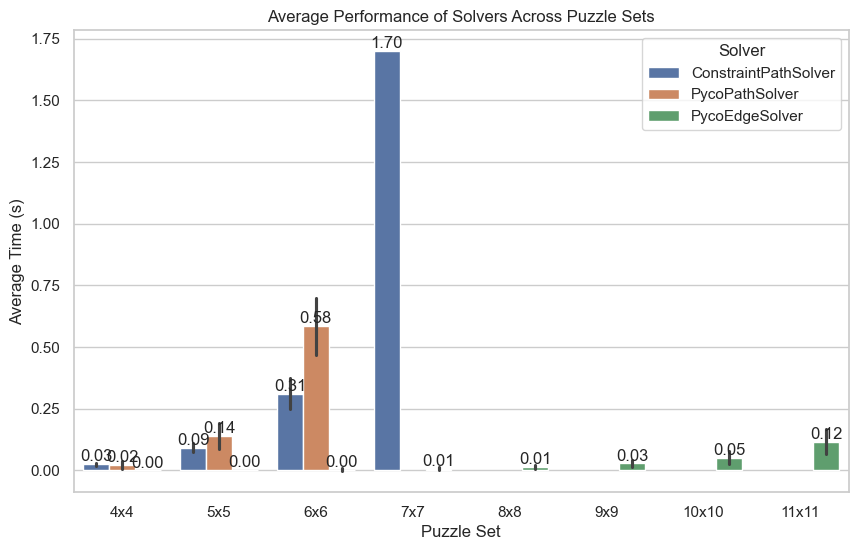

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x="Puzzle Set", y="Time (s)", hue="Solver", data=df_results, errorbar="sd"
)
plt.title("Average Performance of Solvers Across Puzzle Sets")
plt.xlabel("Puzzle Set")
plt.ylabel("Average Time (s)")
plt.legend(title="Solver")

for container in ax.containers:
    ax.bar_label(
        container, fmt="%.2f", label_type="edge"
    )  # "%.2f" formats the label to two decimal places

plt.show()